#Implementing EfficientNetV2L

##Installing the Dataset

In [1]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:23<00:00, 186MB/s]
100% 2.29G/2.29G [00:23<00:00, 103MB/s]


In [2]:
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall()

##Data Augmentation

In [3]:
!pip install tensorflow keras-efficientnet-v2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
dataset_path = "chest_xray"

train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

IMG_SIZE = (480, 480)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class Labels:", class_labels)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Labels: {0: 'NORMAL', 1: 'PNEUMONIA'}


##Model

In [5]:
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(480, 480, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 480, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 480, 480, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 240, 240, 32)   │            864 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 240, 240, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 240, 240, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 240, 240, 32)   │          9,216 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 240, 240, 32)   │            128 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 240, 240, 32)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 240, 240, 32)   │          9,216 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 240, 240, 32)   │            128 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 240, 240, 32)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 240, 240, 32)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 118,075,041 (450.42 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

##Training (With and Without Optimizer)

In [6]:
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.7443 - loss: 0.5669 - val_accuracy: 0.5000 - val_loss: 0.8020
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7396 - loss: 0.5311 - val_accuracy: 0.4375 - val_loss: 0.8786
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.7510 - loss: 0.4895 - val_accuracy: 0.5000 - val_loss: 0.8787
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.7531 - loss: 0.4786 - val_accuracy: 0.6250 - val_loss: 0.8688
Epoch 5/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.7584 - loss: 0.4702 - val_accuracy: 0.6250 - val_loss: 0.8893
Epoch 6/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.7606 - loss: 0.4668 - val_accuracy: 0.6250 - val_loss: 0.9088
Epoch 7/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7706 - loss: 0.4450 - val_accuracy: 0.6250 - val_loss: 0.9091
Epoch 8/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.7668 - loss: 0.4568 - val_accu

In [7]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.8193 - loss: 0.3754 - val_accuracy: 0.8125 - val_loss: 0.3499
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.9435 - loss: 0.1384 - val_accuracy: 1.0000 - val_loss: 0.1078
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.9607 - loss: 0.1091 - val_accuracy: 1.0000 - val_loss: 0.1166
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.9623 - loss: 0.0934 - val_accuracy: 1.0000 - val_loss: 0.0952
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.9628 - loss: 0.0939 - val_accuracy: 0.9375 - val_loss: 0.1643


##Testing and Evaluation Metrics

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 655ms/step - accuracy: 0.8681 - loss: 0.3549
Test Accuracy: 88.78%


39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 665ms/step


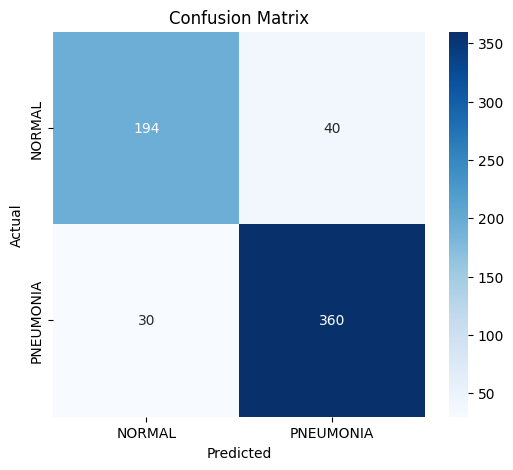

              precision    recall  f1-score   support

      NORMAL       0.87      0.83      0.85       234
   PNEUMONIA       0.90      0.92      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



In [9]:
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_labels.values()))